# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

### Students

* Team: 37
* Students: Isabela Constantin, Adélie Garin, Celia Hacker, Michael Spieler
* Dataset: wikipedia

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

#### Leading note:
For the analysis we used the matrix of the largest weakly connected component. (otherwise there are isolated points and the degree matrix is not invertible for normalized laplacian). We will discuss in the subsequent exercises how this choice is reflected in our results. 


In [3]:
adjacency= np.load('largest_wcc.npz')['arr_0']
n_nodes =  adjacency.shape[0] # the number of nodes in the network

#note: our graph contains selfloops. To compute the Laplacian and do the work below, we delete them (as per slides)
adjacency = adjacency - np.diag(np.diag(adjacency))
n_edges =  int(np.sum(adjacency)/2) # the number of edges in the network

In [4]:
# sanity check that the matrix is also symmetric
(adjacency.T == adjacency).all()

True

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [5]:
# compute combinatorial laplacian
degree_matrix = sparse.spdiags(np.sum(adjacency,axis=0), 0, n_nodes, n_nodes)
adjacency = sparse.csr_matrix(adjacency)
laplacian_combinatorial =  degree_matrix - adjacency

In [6]:
# compute normalised laplacian
# first compute D^(-1/2),we can make it into a matrix after
D_inv_sq = 1 / np.sqrt(np.sum(adjacency,axis=0))
D_inv_sq = sparse.spdiags(D_inv_sq, 0, n_nodes, n_nodes)
laplacian_normalized = sparse.eye(n_nodes) - D_inv_sq @ adjacency @ D_inv_sq

In [7]:
laplacian_normalized

<4589x4589 sparse matrix of type '<class 'numpy.float64'>'
	with 217657 stored elements in Compressed Sparse Row format>

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [8]:
# we get generally better results using the normalized laplacian
laplacian = laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [9]:
eigenvalues_norm, eigenvectors_norm = np.linalg.eigh(laplacian_normalized.toarray())
# ensure it is sorted
(np.sort(eigenvalues_norm) == eigenvalues_norm).all()

True

In [10]:
# note that due to limited floating point precision lambda_1 is not exactly 0 (but very close)
eigenvalues_norm

array([2.26009121e-16, 2.28689668e-01, 2.76081918e-01, ...,
       1.38741627e+00, 1.39632479e+00, 1.52088677e+00])

In [11]:
# do the same for combinatorial
eigenvalues_comb, eigenvectors_comb = np.linalg.eigh(laplacian_combinatorial.toarray())
# ensure it is sorted
(np.sort(eigenvalues_comb) == eigenvalues_comb).all()

True

In [12]:
eigenvalues_comb

array([4.97730658e-14, 8.72090315e-01, 9.70810995e-01, ...,
       9.96070193e+02, 1.04705843e+03, 1.62201828e+03])

Justify your choice of eigensolver.

**Your answer here.** 

We need to do find out all the eigenvalues and eigenvectors, so we used the solution provided in np.linalg. 

There was no need to use scipy since we are not dealing with a generalised eigenvalue problem .

Lastly, we used `numpy.linalg.eigh` since L is *symmetric*

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

S is the incidence matrix, it takes edges and returns which vertices they link (size: nb_nodes* nb_edges). $(S)_{ij}$ is +1 (resp -1) if the j-th edge has source (resp sink) the node i, $(S)_{ij}$ is 0 if the j-th edge is not incident to i. 

$S^\top$ takes nodes and return edges (size: nb_edges*nb_nodes). The vector x is a signal on the nodes (it assigns a real value to each node) and $S^\top x$ is then a signal on the edges. It is the gradient of this node-signal x, i.e. the difference of the signal of the end-nodes of each edge. If the k-th edge has source i and sink j, $(S^\top x)_k = x_i-x_j$ (here we consider the unweighted case, otherwise there is a square root of the weight that comes up). 

Note: We need an orientation to define those properly, but in the case of undirected graph we can just define a random orientation. 

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

Finding eigenvalues of L is solving the equation $Lx = \lambda x $. Assume $ \|x \|=1$. 

Then is it equivalent to solving $x^\top Lx = x^\top \lambda x$ which is equivalent to solve $x^\top S S^\top x = x^\top \lambda x$ (as $L= S^\top S$). 

This gives the equation $\lambda=\frac{(x^\top S S^\top x)}{(x^\top x )}=\frac{ \| S^\top x \|_2^2}{ \| x \|_2 ^2 } $. Hence solving $Lx = \lambda x $ for $ \|x \|=1$ is equivalent to solving $\| S^\top x \|_2^2 = \lambda$ for $\| x \|_2 ^2 =1 $, and for the eigenvalue $\lambda_k$ we have the associated eigenvector $u_k$ of norm 1 satisfying $\lambda_k = \| S^\top u_k \|_2^2$.

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

$\| S^\top x \|_2^2$ is the squared norm of the gradient of the signal x : $\| S^\top x \|_2^2 = x^\top S S^\top x = \sum_{i,j} (x_i-x_j)^2$ (unweighted case again). The smallest it is, the smoothest the signal x is (meaning the difference of signal at each edge is small). If $\| S^\top x \|_2^2 = 0$ then the signal x is constant, the smoothest possible. 

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your answer here.**

For the combinatorial Laplacian L, minimizing $\| S^\top x \|_2^2$ corresponds to finding the first eigenvalue of L = $S^\top S$. As mentionned in Question 4, there is always the possibility of having a constant signal x and hence $\| S^\top x \|_2^2 = 0$ . The first eigenvalue is always 0, and its associated eigenvector of norm 1, $u_0$, is always constant. Its value is then $u_0 = (a ,..., a)$ where a is such that $a^2+...+a^2 = 1$ (norm of x is 1). 

The normalized Laplacian eigenvalues $ \{f_0,...f_k \} $ are linked to the ones of the combinatorial Laplacian $ \{u_0,...u_k\}$ by $u_i = D^{-1/2} f_i $, where D is the degree matrix. If we want eigenvectors of norm 1 we just divide $u_i = D^{-1/2} f_i $ by its norm. 


In [13]:
# sanity check: constant first eigenvector of the combinatorial laplacian
eigenvectors_comb[:, 0]

array([0.01476186, 0.01476186, 0.01476186, ..., 0.01476186, 0.01476186,
       0.01476186])

In [14]:
# obtaining it from the first eigenvector of the normalised laplacian
D_inv_sq.dot(eigenvectors_norm[:, 0]) / np.linalg.norm(D_inv_sq.dot(eigenvectors_norm[:, 0]),2)

array([0.01476186, 0.01476186, 0.01476186, ..., 0.01476186, 0.01476186,
       0.01476186])

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

In [15]:
def plot_eigen(eigenvalues, title ):
    fig = plt.figure()
    ax = plt.gca()
    n_eigenvalues = eigenvalues.shape[0]
    ax.plot(range(n_eigenvalues),eigenvalues, 'o', c='blue', markeredgecolor='none', markersize= 3.5)
    plt.xlabel('The n-th eigenvalue')
    plt.ylabel('eigenvalue')
    plt.title(title)

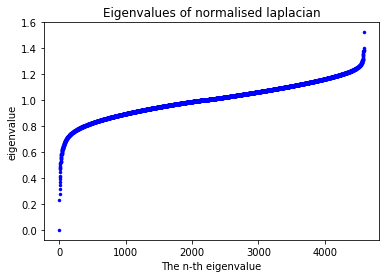

In [16]:
plot_eigen(eigenvalues_norm,'Eigenvalues of normalised laplacian' )

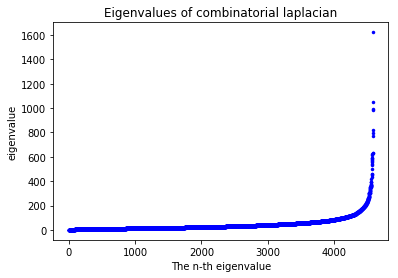

In [17]:
plot_eigen(eigenvalues_comb, 'Eigenvalues of combinatorial laplacian')

**Your answer here.**
We can see that there is only one 0-eigenvalue. Eigenvalues are supposed to be the minimum of $ \| S^\top x \|_2^2 $ with constraint to be orthognal to the previous eigenvalues in the list. They are hence signals on the nodes ordered by smoothness. 
Eigenvalues of the normalized Laplacian are between 0 and 2, as expected. On the plot of the normalized Laplacian, we can see a clear gap between the first eigenvalue 0 and the first non zero one (the normalization helped to visualize here).

How many connected components are there in your graph? Answer using the eigenvalues only.

Note that we don't have exact precision, so we round up our eigenvalues to 12 decimals, and we see the first eigenvalue is 0, while the next are much bigger. 

In [18]:
# The number of connected components is the number of eigenvalues with value 0. 
print(np.round(eigenvalues_norm, decimals=12))

[0.         0.22868967 0.27608192 ... 1.38741627 1.39632479 1.52088677]


We can see there is only one zero eigenvalue ( we know the eigenvalues are in order, the second largest one is clearly non zero). 
Hence, one connected component (as expected, since we took the graph of the biggest connected component).

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

Combinatorial Laplacian: By Gershgorin circle theorem, any eigenvalue of a matrix is bounded by the largest absolute value sum of its row and columns. In our case, it gives twice maximal degree of the graph. This is unbounded, we can find a serie of graphs whose Laplacian eigenvalues go to infinity. 

Normalized Laplacian: One of the idea behind normalized Laplacian is to get bounded eigenvalues. The eigenvalues of the normalized Laplacian are all contained between 0 and 2. (the value 2 is attained if the graph has a complete bipartite component). 

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

The goal of Laplacian eigenmaps is to reduce dimension of the data while keeping important similarity properties. Points that are similar (meaning, close to each other) in the original graph will be close to each other in the embedding.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [19]:
# normalized spectral clustering
L = laplacian_normalized.asfptype() # cast to float first
eigenval_norm, eigenvec_norm = sparse.linalg.eigsh(L, k=3, which='SM')
eigenval_norm

array([1.53209696e-16, 2.28689668e-01, 2.76081918e-01])

In [20]:
# the first eigenvector is the constant signal, we take the second and the third
eigenmaps_norm = eigenvec_norm[:,1:3]
# re-normalise by degree
eigenmaps_renorm = D_inv_sq @ eigenmaps_norm

Plot the nodes embedded in 2D. Comment on what you see.

Text(0.5, 1.0, 'Eigenmaps with eigenvectors of normalised laplacian ')

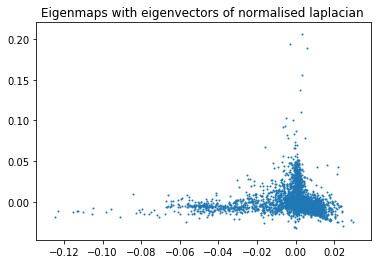

In [21]:
plt.scatter(eigenmaps_norm[:,0],eigenmaps_norm[:,1],s=1)
plt.title('Eigenmaps with eigenvectors of normalised laplacian ')

Text(0.5, 1.0, 'Eigenmaps with eigenvectors renormalised by the degree')

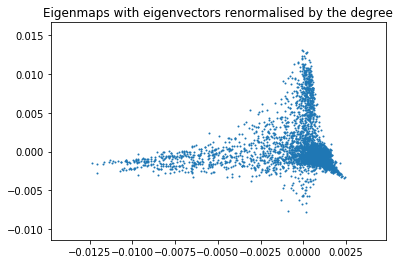

In [22]:
plt.scatter(eigenmaps_renorm[:,0],eigenmaps_renorm[:,1],s=1)
plt.title('Eigenmaps with eigenvectors renormalised by the degree')

**Your answer here.**

The eigenmaps from the re-normalized eigenvectors have less outliers which is preferred for clustering.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

The embedding preserve smoothness of the signal. If we cluster the embedding, we obtain a good clustering of the original graph as well. 

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

If there are k clear clusters in the data, then there will be a gap in the Laplacian spectrum after the k-th eigenvalue.

Therefore should choose the dimension d = k clusters.

However, when plotting the eigenvalues from the normalized Laplacian, we don't really find any clear gap. Therefore, we tried multiple values for k and finally we choose k=16 klusters which is explained later.

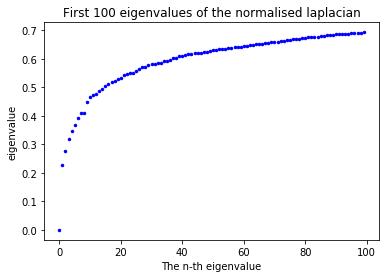

In [23]:
plot_eigen(eigenvalues_norm[:100], 'First 100 eigenvalues of the normalised laplacian')

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

(4589, 16)


(array([1194.,    8., 1968.,  121.,  340.,   67.,  157.,  118.,  351.,
         265.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

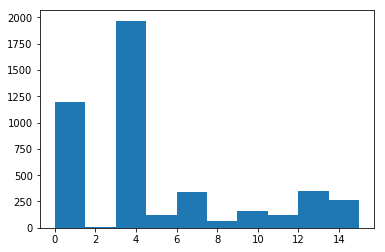

In [24]:
k=d=16

# normalized spectral clustering
L = laplacian_normalized.asfptype() # cast to float first
eigenval, eigenvec = sparse.linalg.eigsh(L, k=d+1, which='SM')

eigenmaps = eigenvec[:,1:d+1]
eigenmaps = D_inv_sq @ eigenmaps # re-normalise by degree
print(eigenmaps.shape)

kmeans = KMeans(n_clusters=k).fit(eigenmaps)
cluster_assignment = kmeans.labels_

plt.hist(cluster_assignment)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

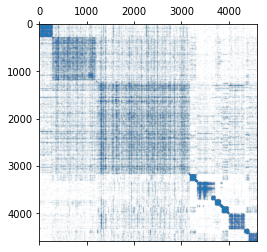

In [25]:
sorted_index = np.argsort(cluster_assignment)

adjacency_clustered = np.empty((n_nodes, n_nodes), dtype=adjacency.dtype)
adjacency.todense(out=adjacency_clustered) # copy matrix to dense
adjacency_clustered=adjacency_clustered[:,sorted_index][sorted_index,:] # reorder rows and columns

plt.spy(adjacency_clustered, markersize=0.01)

**Your answer here.**

One would expect denser connections around the diagonal like a block diagonal matrix.
Because nodes within the same cluster are well connected and in the sorted adjacency matrix they are also next to each other.

This is clearly the case, and as we can take from the cluster size histogram from Q11 the classes are slightly imbalanced.

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

The ground truth has 16 categories (see apendix for the methodolgy we used to determine those). Therefore we chose k=16 to compare with the k-means clustering.

(16,)


Text(0.5, 1.0, 'Ground truth clusters')

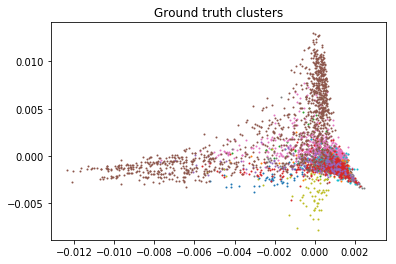

In [26]:
import pandas as pd
df_labels = pd.read_pickle('df_labels.pickle')

labels = np.unique(df_labels['level_1'])
print(labels.shape)
for l in labels:
    cluster = eigenmaps_renorm[df_labels['level_1'] == l]
    plt.scatter(cluster[:,0],cluster[:,1], s=1)
plt.title('Ground truth clusters')

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

Text(0.5, 1.0, 'Computed clusters')

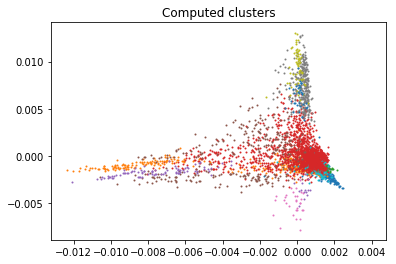

In [27]:
for i in range(k):
    cluster = eigenmaps_renorm[cluster_assignment==i]
    plt.scatter(cluster[:,0],cluster[:,1], s=1)
plt.title('Computed clusters')

By comparing the images, we can see the resulting clusterings are quasi similar. (But note that the ground truth clusters are quite interspersed, and there are no clear cut clusters in the data, as expected from the eigenvalue plots).

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**

Each eigenvector minimize the gradient of the signal ($\sum (x_i-x_j)$) up to the condition to be orthogonal to the previous eigenvectors. Hence, the first eigenvectors each gives rise to a as-smooth-as-possible signal, where points that are close have close signal value and points that are far away have larger difference of values. It returns a good clustering. There are other methods to cluster a graph, for example one could use k-mean on nearest neigbors without using eigenvectors. The utility of projection on eigenvectors spaces in the reduction of dimension. 

## Appendix: Finding labels for wiki dataset

In [28]:
df_labels = pd.read_pickle('../milestone1/article_df_larg_wcc.pickle')
print(df_labels.shape)
df_labels.tail()

(4589, 3)


,index,article,category
4594,4594,Édouard_Manet,[subject.People.Artists]
4595,4595,Éire,"[subject.Countries, subject.Geography.European..."
4596,4596,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...
4597,4597,€2_commemorative_coins,[subject.Business_Studies.Currency]
4599,4599,Pikachu,NaN


In [29]:
number_attributes = np.array([len(cat) if type(cat)!=float else 0 for cat in df_labels.category])

### The distribution of number of labels per node: 
note most have just 1. Because k-means does hard clustering, for the ones that have more than 1 label, we decide we randomly select just one. 

(array([1.00e+00, 0.00e+00, 0.00e+00, 3.99e+03, 0.00e+00, 0.00e+00,
        5.90e+02, 0.00e+00, 0.00e+00, 8.00e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

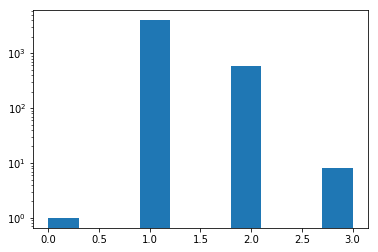

In [30]:
# just to show there are labels with 0 or 3 attributes
plt.hist(number_attributes, log=True)

In [31]:
def select_random_label(cat_list):
    if type(cat_list) == float:
        return 'None'
    elif len(cat_list) == 1:
        return cat_list[0]
    rand_idx = np.random.randint(0, len(cat_list))
    return cat_list[rand_idx]

In [32]:
df_labels['selected_category'] = df_labels.category.apply(select_random_label)

In [33]:
df_labels.tail()

,index,article,category,selected_category
4594,4594,Édouard_Manet,[subject.People.Artists],subject.People.Artists
4595,4595,Éire,"[subject.Countries, subject.Geography.European...",subject.Countries
4596,4596,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...,subject.People.Historical_figures
4597,4597,€2_commemorative_coins,[subject.Business_Studies.Currency],subject.Business_Studies.Currency
4599,4599,Pikachu,NaN,None


### The distribution of levels per label

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.510e+02, 0.000e+00, 0.000e+00,
        3.162e+03, 0.000e+00, 0.000e+00, 1.275e+03]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

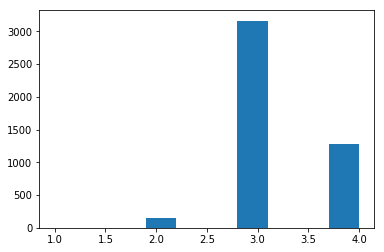

In [34]:
df_labels.selected_category = df_labels.selected_category.apply(lambda x: x.split('.'))
number_levels = [len(levels) for levels in df_labels.selected_category]
plt.hist(np.array(number_levels))

In [35]:
df_labels['level_0'] = [label[0] for label in df_labels.selected_category]
df_labels.groupby('level_0').size()

level_0
None          1
subject    4588
dtype: int64

In [36]:
# that renders a useless clustering since all pages with a category have as root subject. Remove column
df_labels.drop('level_0', inplace=True, axis=1)

In [37]:
df_labels['level_1'] = [label[1] if len(label)>1 else 'None' for label in df_labels.selected_category]
level_1_labels = df_labels.groupby('level_1').size()
level_1_labels

level_1
Art                          35
Business_Studies             82
Citizenship                 205
Countries                   107
Design_and_Technology       225
Everyday_life               330
Geography                   937
History                     463
IT                           77
Language_and_literature     178
Mathematics                  44
Music                        96
None                          1
People                      627
Religion                    120
Science                    1062
dtype: int64

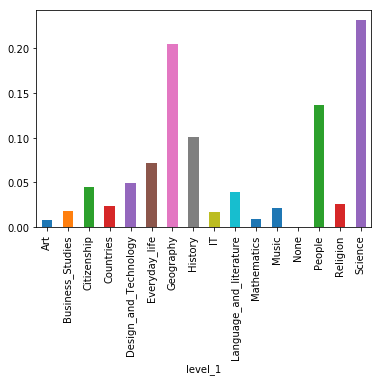

In [38]:
# plot it in terms of percentage
level_1_labels = level_1_labels / sum(level_1_labels)
level_1_labels.plot(kind='bar')

In [39]:
print(' There are ', len(level_1_labels), ' categories of level 1 ')

 There are  16  categories of level 1 


Note they are not balanced, but it can lead to a potentially good choice of the number of clusters k. 

In [40]:
df_labels['level_2'] = [label[2] if len(label)>2 else 'Unk' for label in df_labels.selected_category]
level_2_labels = df_labels.groupby('level_2').size()
level_2_labels.head(10)

level_2
Actors_models_and_celebrities                       25
African_Geography                                  108
Air_and_Sea_transport                               18
Ancient_History_Classical_History_and_Mythology     73
Animal_and_Human_Rights                             15
Antarctica                                           8
Archaeology                                         10
Architecture                                        49
Art                                                 33
Artists                                             38
dtype: int64

In [41]:
print(' There are ', len(level_2_labels), ' categories of level 2 ')

 There are  102  categories of level 2 


That is a way too high number of clusters, and the resulting categories have a high overlap, as it can be seen even in the first 10 (i.e. Art and Artists). Given the relatively small sample size we have, we decide that only clustering based on 'level 1' would be meaningful. 

In [42]:
# uncomment to save pickled dataframe
#df_labels.to_pickle('df_labels.pickle')